### 0.
Install pacakges:

```python
pip install aicsimageio
pip install cellpose
```

Download models:

Make sure you are running this notebook with access to a GPU. If you don't have access, set the parameter gpu=False (below), but be warned that running model inference will take much longer.

In [1]:
#### ADD CUSTOM PATH ###
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant'

In [2]:
import sys
sys.path.append(path_to_quant)

In [47]:
from confocalQuant.segmentation import toggle_filters, load_3D, int_to_float, get_czi_files, import_im, run_med_filter, get_anisotropy, do_inference, toggle_segmentation, float_to_int
from aicsimageio import AICSImage
from cellpose import models

### 1.
First, specify which channels to load from the image listed in path. You can specify as many channels as you want. Takes .czi files as input.

In [29]:
### remove flagged images
flagged = set(['C10-1',
'C09-1',
'C06-1',
'B10-1',
'B07-1',
'B06-1',
'B05-1',
'B04-1',
'B03-1',
'G11-1',
'G08-1',
'G05-1',
'F09-1',
'F03-1',
'F02-1',
'D04-1',
'C08-1',
'C04-1',
'B08-1'])

parent_path = '../../data/neuronbatch102523_cellrox/'
all_files_present = np.array(get_czi_files(parent_path))
keep_files_index = np.where([x.split('.')[0] not in flagged for x in all_files_present])[0]
all_files = all_files_present[keep_files_index]

In [157]:
# specify channels to load
channels = [0,1,2] #### ADD CUSTOM CHANNELS ####

toggle_filters(all_files_present[keep_files_index[12:14]], parent_path, channels)


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]



Visualize the image by toggling through the different parameters:

- *show*: select which channels you want to show. Hold shift to select multiple channels at once. A maximum of 3 channels can be selected at once. Channels will be shown as Red, Green, Blue in ascending order. To modify this, change the order in which you load the channels above. 
- *adjust*: toggle which images to adjust with sliders below
- *zi_slider*: toggle through images on the z-axis
- *gamma_slider*: apply gamma filter for visualization. 
- *median slider*: apply median filter to remove sensor noise
- *background slider*: subtract background signal from all values (in %).
- *lower_slider*: set values below this threshold to 0 (in %).
- *upper_slider*: set values above this threshold to max value (in %).

N.B. The first time you call the function toggle_filters will take longer than subsequent rounds, as some of the code gets compiled into machine code first, to substantially speed up the functions in subsequent calls.

In [ ]:
### list additional indices in all_files to remove based on toggling above

### 3.
Choose parameters above that remove background signal (from tissue autofluorescence or contaminating cells), smooth over sensor noise if present, remove outlier signal and highlight the cells you care about segmenting. However, don't go overboard with thesholding, otherwise the model will have trouble. Only the channels you will actually be using in the model should be adjusted in this way (i.e. a cell body marker and, optionally, a nuclear marker).

In [30]:
### MODIFY BASED ON SETTINGS ABOVE ###
kernel = 1 # (i.e. median filter value)
background_dict = {0: 0, 1: 95, 2: 0.0} # (i.e. for every channel, background value)
gamma_dict =  {0: 1, 1: 1, 2: 1} # (i.e. for every channel, the gamma value)
lower_dict = {0: 0, 1: 0, 2: 0} # (i.e. for every channel, the lower value)
upper_dict =  {0: 100, 1: 99.9, 2: 100} # (i.e. for every channel, the upper value)
channels = [0,1,2]

In [36]:
# import example image
path = parent_path + all_files_present[keep_files_index[16]]
img = AICSImage(path)
out_float = import_im(path, channels)

In [37]:
# apply the filters
out_med = run_med_filter(out_float, kernel = kernel)
out_float_subtract = bgrnd_subtract(out_med, np.array(list(background_dict.values())))
g_correct = gamma_correct_image(out_float_subtract,  gamma_dict, lower_dict, upper_dict)

100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


### 4.

Perform model segmentation. Start with the default parameters, then go back to modify them once you've viewed initial results. 

In [38]:
### MODEL PARAMS ###

diameter=20 # expected cell body diameter in um
inf_channels=[2,0] # channels to use for segmentation. 1=red, 2=green, 3=blue; see the image above to determine what colors you care about. First position = cell body channel. Second position = nuclear channel. If you don't want to use a nuclear channel for segmentation, enter '0' in the second position.
min_size=500 # minimum number of expected points ("voxels") per cell

In [43]:
# get anisotropy
anisotropy = get_anisotropy(img)
print('Anisotropy: ' + str(anisotropy))

# load model
model = models.Cellpose(gpu = True, model_type='cyto2')

# run inference
masks, flows = do_inference(g_correct, do_3D=True, model=model, anisotropy=anisotropy, diameter=diameter, channels=inf_channels, channel_axis=3, z_axis=0, min_size=min_size, normalize = False)

Anisotropy: 2.0034434183753325


### 5. 
Toggle through the segmentation results to evaluate them.

In [48]:
# toggle through segmentation
extracted = extract_channels([1], g_correct) # enter which channels to show here (up to 3 channels)
toggle_segmentation(float_to_int(extracted), masks) # you can optionally pass out_float, out_med, out_float_subtract, or apply different filters to out_float to help with the visualization

In [217]:
def show_meanproj_with_outlines(mat2, masks):
    max_proj = np.max(mat2, axis=(0))

    for i in tqdm(range(masks.shape[0])):
        M = find_boundaries(masks[i], mode = 'outer', background = 0)
        max_proj[:,:,0][np.where(M)] = 255
        max_proj[:,:,1][np.where(M)] = 255
        max_proj[:,:,2][np.where(M)] = 255


    return max_proj

100%|██████████| 20/20 [00:01<00:00, 19.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


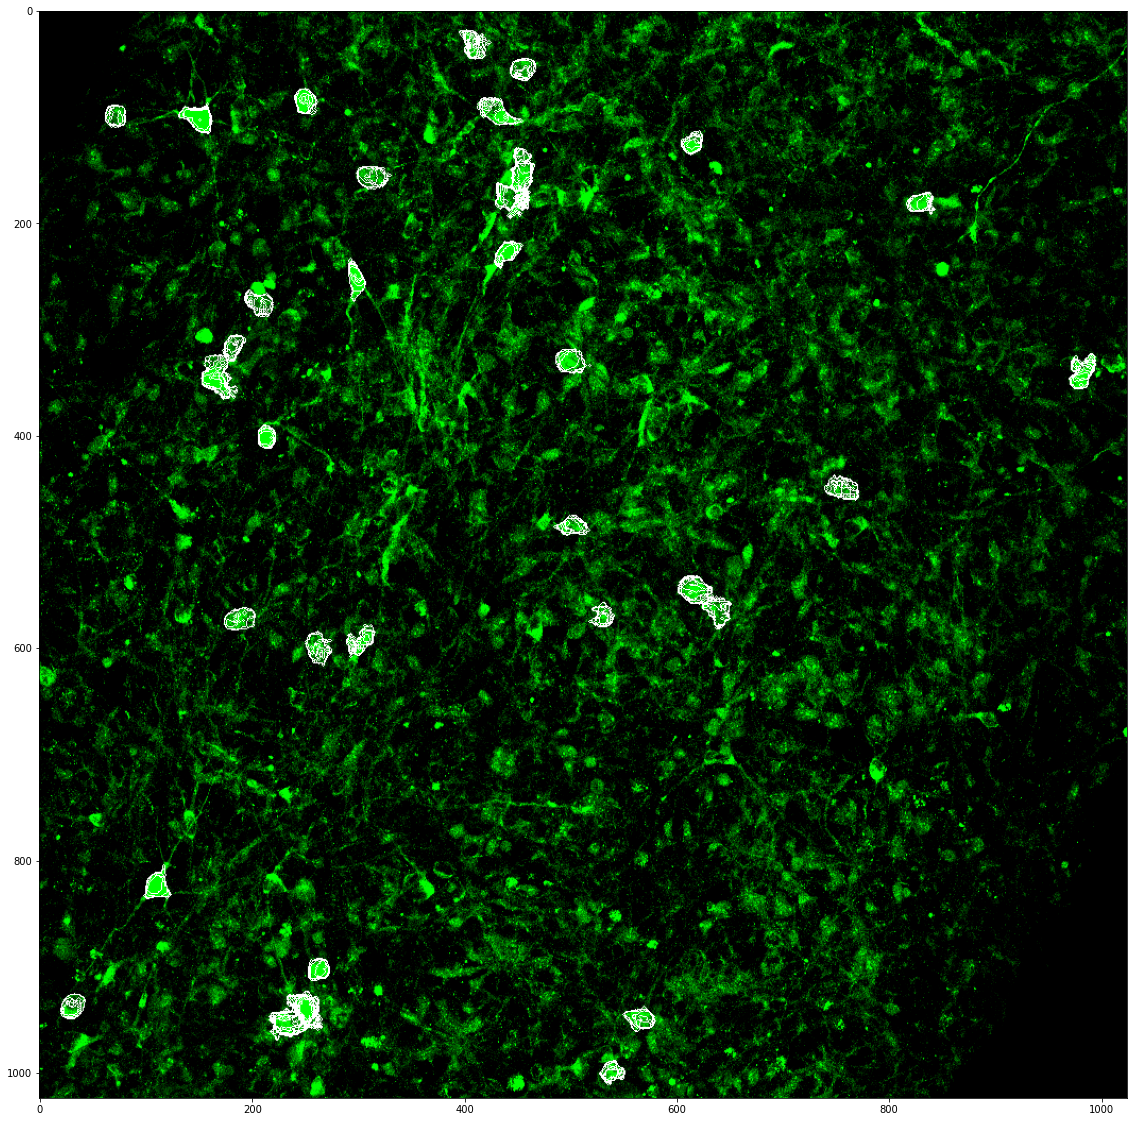

In [218]:
plt.figure(figsize=(20,20))
temp = extract_channels([1], g_correct)
temp = show_meanproj_with_outlines(temp,masks)
plt.imshow(temp**1)

100%|██████████| 20/20 [00:01<00:00, 19.38it/s]


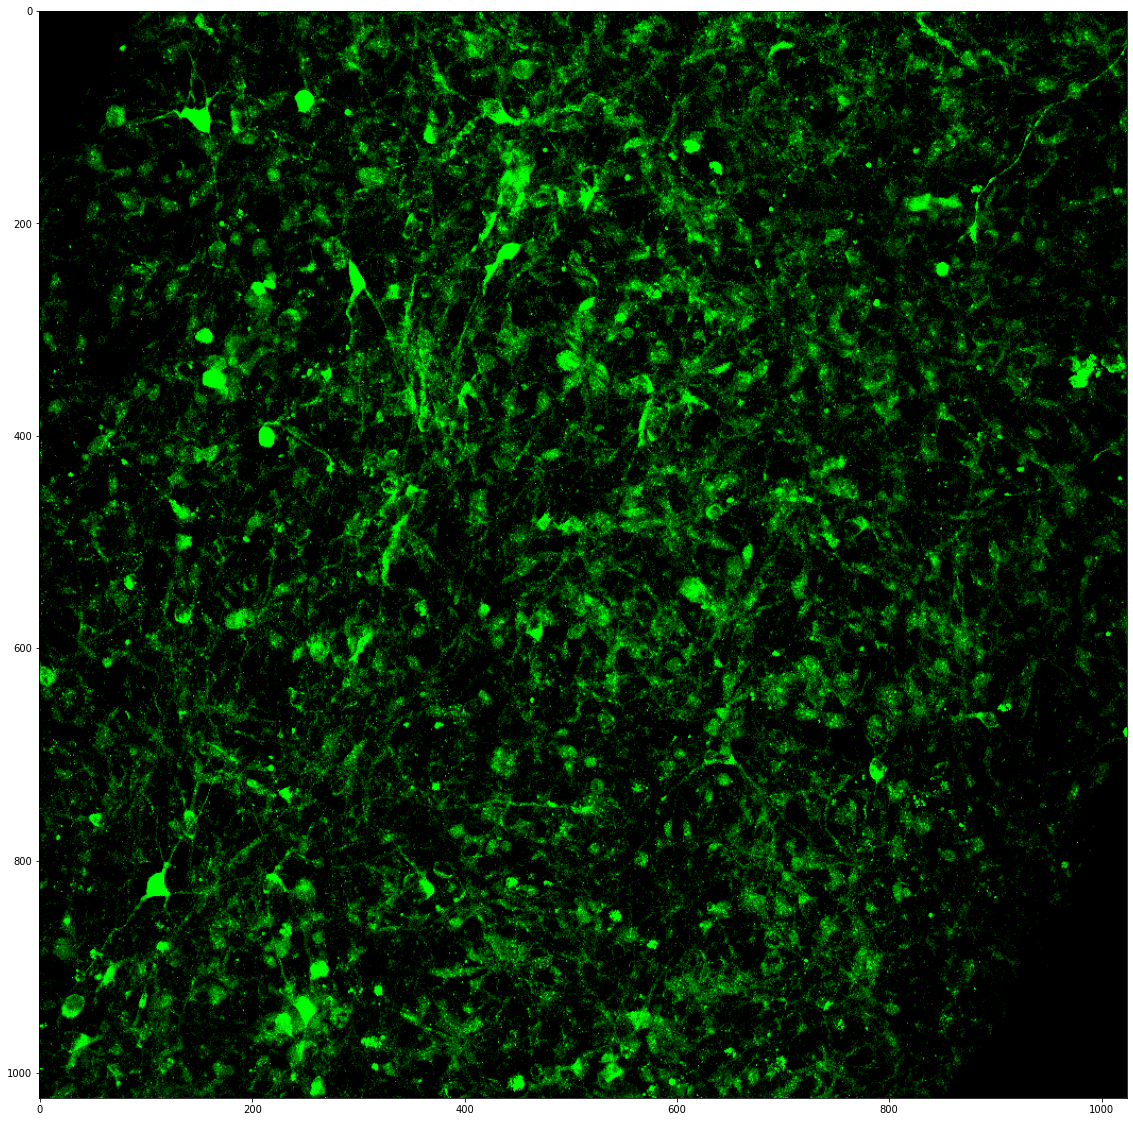

In [219]:
plt.figure(figsize=(20,20))
temp = extract_channels([1], g_correct)
m = masks.copy()
m[m>0]=0

temp = show_meanproj_with_outlines(temp,m)
plt.imshow(temp**1)

In [185]:
temp.shape

(1024, 1024, 3)

In [125]:
len(all_files_present)

51

In [124]:
img.data.shape

(1, 3, 20, 1024, 1024)

### 6. 
You may want to repeat steps 1-5 to make sure the parameters you are choosing work well for different images.
Once you've found good parameters, modify the example.sbatch file to do inference on all your images.

```bash
sbatch example.sbatch
```

In [9]:
from confocalQuant.plotting import get_out_files, is_string_present
from tqdm import tqdm

In [14]:
# Do all the SBATCH files for the IDs we care about say done?

out_files = get_out_files('./')
out_files = np.array(out_files)[np.argsort([int(x.split('_')[1].split('.')[0]) for x in out_files])]
res = []
for file in out_files:
    res.append((file, is_string_present(file, 'done')))
    
res

[('slurm-24383720_0.out', True),
 ('slurm-24383720_1.out', True),
 ('slurm-24383720_2.out', True),
 ('slurm-24383720_3.out', True),
 ('slurm-24383720_4.out', True),
 ('slurm-24383720_5.out', True),
 ('slurm-24383720_6.out', True),
 ('slurm-24383720_7.out', True),
 ('slurm-24383720_8.out', True),
 ('slurm-24383720_9.out', True),
 ('slurm-24383720_10.out', True),
 ('slurm-24383720_11.out', True),
 ('slurm-24383720_12.out', True),
 ('slurm-24383720_13.out', True),
 ('slurm-24383720_14.out', True),
 ('slurm-24383720_15.out', True),
 ('slurm-24383720_16.out', True),
 ('slurm-24383720_17.out', True),
 ('slurm-24383720_18.out', True),
 ('slurm-24383720_19.out', True),
 ('slurm-24383720_20.out', True),
 ('slurm-24383720_21.out', True),
 ('slurm-24383720_22.out', True),
 ('slurm-24383720_23.out', True),
 ('slurm-24383720_24.out', True),
 ('slurm-24383720_25.out', True),
 ('slurm-24383720_26.out', True),
 ('slurm-24383720_27.out', True),
 ('slurm-24383720_28.out', True),
 ('slurm-24383720_29.out

### 7. 

Load, explore, and plot quantifications of the results.

In [15]:
import numpy as np
from confocalQuant.segmentation import extract_sbatch_parameters, get_czi_files, impose_segmentation_all, toggle_filters
from confocalQuant.plotting import return_results, concatenate_Y, add_metadata, exclude_files, modify_keep_files, filter_data

In [16]:
#### SPECIFY PATH TO SBATCH FILE ###
path_to_sbatch_file = '../neuronbatch102523_cellrox_out/run_jobs_102523_cellrox.sbatch'
path_to_czi_files = '../../data/neuronbatch102523_cellrox/'
nuclear_col_idx = 0
soma_col_idx = 1
nuclear_percentile = 0 
soma_percentile = 0
colnames = ['DAPI', 'NeuN', 'cellrox', 'cellrox-b', 'ID']
path_to_meta = '../../data/neuronbatch102523_cellrox/temp.csv'

In [17]:
# load & concatenate the data
mat, masks, Y, Ncells, Nzi, cells_per_job, zi_per_job = return_results(path_to_sbatch_file)
all_file_names = get_czi_files(path_to_czi_files)

# for file 50 whose job failed, but are leaving out anyway
Ncells_copy = Ncells.copy()
Nzi_copy = Nzi.copy()
Ncells_copy[-1] = 20
Nzi_copy[-1] = 20

data = concatenate_Y(all_file_names, Y, cells_per_job, Ncells_copy, nuclear_col_idx, soma_col_idx, nuclear_percentile, soma_percentile, colnames)
add_metadata(data, path_to_meta)

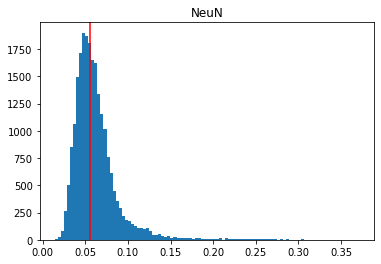

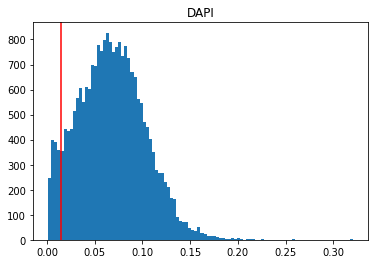

In [20]:
# filter cells based on NeuN and DAPI
data_filtered = filter_data(data, 'NeuN', 'DAPI', 'wellname', C_nuc=1.5, C_soma=.25)
# update masks based on this for toggling

In [21]:
data_filtered.shape

(11217, 9)

In [27]:
channels = [0,1,2] #### ADD CUSTOM CHANNELS ####


In [25]:
# toggle segmentation
val = 0.5
out_float = []
for i in tqdm(range(len(keep_files_index))): #
    out_float.append(impose_segmentation_all(keep_files_index[i], zi_per_job, Nzi, mat, masks, val, data, data_filtered, hide=True))

100%|██████████| 32/32 [02:47<00:00,  5.23s/it]


In [28]:
toggle_filters(keep_files_index, parent_path, channels, out_float)

### 8. 
Remove cells from flagged images

In [65]:
# specify additional images to remove
ids_remove = set()
keep_files = set(keep_files_index[[x not in ids_remove for x in keep_files_index]])

# modify data to only include the keep_files IDs
data_filtered = data_filtered[[int(x) in keep_files for x in data_filtered['ID']]]

In [45]:
# #### SPECIFY ADDITIONAL IDS TO REMOVE ####
# Ncells_per_file = 50 # specify min Ncells per file
# files, counts = np.unique(data_filtered['wellname'], return_counts=True)
# keep_files = np.argwhere([x.split('-')[0] in set(files[counts>Ncells_per_file]) for x in all_file_names]).reshape(-1)
# ids_remove = set([2,0]) # additional IDs to remove
# keep_files = set(keep_files[[x not in ids_remove for x in keep_files]])



### 9. 
Plot effects

In [ ]:
# plot effects
plot_effect(data, 'condition', 'G2 vehicle', 'G2 CDP-choline', 'mito-b')

In [ ]:
# mixed model quantification

In [ ]:
# check that all images used have <40 Zi, <300 cells, physical pixel size, pinhole size etc 

### 10.
Representative images.

In [31]:
from confocalQuant.segmentation import bgrnd_subtract, gamma_correct_image, extract_channels, impose_segmentation, float_to_int, hide_masks
from confocalQuant.plotting import add_scale_bar, add_inset, plot_axis, get_id_data, get_mean_projections, compute_avs, get_rep_im
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage


In [32]:
# get rep images
dict_treat = dict(zip(data['filename'], data['treatment']))
dict_line = dict(zip(data['filename'], data['line']))

mean_per_filename, mean_per_condition = compute_avs(data, 'filename', 'treatment', 'line', 'mito-b')
treat_rep = get_rep_im('rosiglitazone', 'Y622', all_files_present, mean_per_condition, mean_per_filename, dict_treat, dict_line)
vehicle_rep = get_rep_im('vehicle', 'Y622', all_files_present, mean_per_condition, mean_per_filename, dict_treat, dict_line)

In [33]:
np.unique(data['treatment'])

array(['CDP-choline', 'GW501516', 'rosiglitazone',
       'sn-glycero-3-phosphocholine', 'vehicle'], dtype=object)

In [34]:
collabs = ['NeuN','NeuN+DAPI',  'NeuN Mask', 'Mitohealth']
rowlabs = ['Y622 + vehicle', 'Y622 + Rosi']

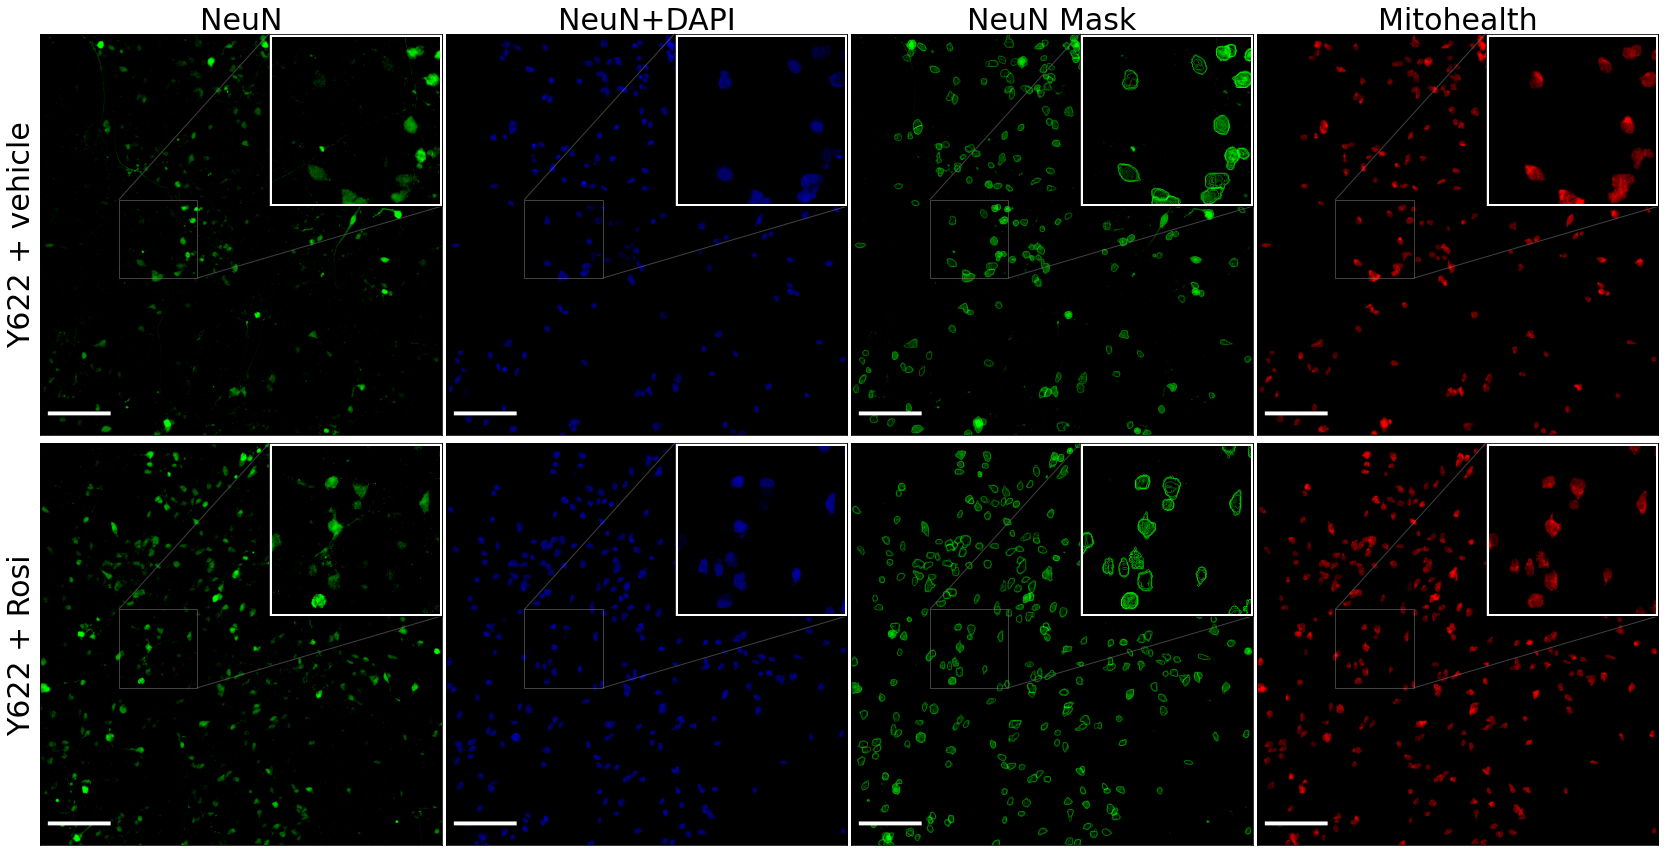

In [35]:
# get data for a specific ID
conditions = [vehicle_rep, treat_rep]#vehicle_rep
fig, axes = plt.subplots(2, 4, figsize=(29, 15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust the spacing

for i in range(len(conditions)):
    ID = conditions[i]
    mat_sele, mask_sele = get_id_data(ID, zi_per_job, Nzi, mat, masks)
    mask_sele = hide_masks(data, ID, data_filtered, mask_sele)
    
    # make plots
    plt0 = get_mean_projections(mat_sele, mask_sele, background_dict={0: 0, 1: 99.5, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .5}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 99.9, 2: 100}, channels=[0], order=[2,1,0], mask_channel = [0], maskit=True)
    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict={0: 0, 1: 99, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .9}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 100, 2: 99.9}, channels=[2], order=[2,1,0], mask_channel = [2], maskit=True)
    d = impose_segmentation(mask_sele, mat_sele, val=1)
    plt2 = get_mean_projections(d, mask_sele, background_dict={0: 0, 1: 99, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .5}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 99.9, 2: 100}, channels=[1], order=[2,1,0], mask_channel = [0], maskit=True)
    plt3 = get_mean_projections(mat_sele, mask_sele, background_dict={0: 0, 1: 99.5, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .5}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 99.9, 2: 100}, channels=[1], order=[2,1,0], mask_channel = [0], maskit=True)

    # get image
    imgA = AICSImage(path_to_czi_files + all_file_names[ID])

    # show plots
    plot_axis(axes, plt3, i,0, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,0, plt3)

    plot_axis(axes, plt2, i,2, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,2, plt2)

    plot_axis(axes, plt0, i,1, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,1, plt0)

    plot_axis(axes, plt1, i,3, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,3, plt1)
    


#fig.savefig('test.png')


In [24]:
# add mixed model quantification to account for well effects
# check the KDE plot
# some quantification of FPR and TPR to take into account for effect size quantification etc 

# print how much the magnification is in upper right corner
# add thresholding across two images so that comparable (upper=99.9%)


(6900, 5)